# SWMM5 Culvert Sensitivity Analysis

Refer to [my notebook](https://github.com/mel-meng/SewerAnalysis/blob/master/examples/culvert/2%20SWMM5%20Culvert%20theory.ipynb) for more information on the swmm5 culvert theory.

In this notebook I will use DG 1.3.1 from HDS5 to see which parameters will impact the SWMM5 results.

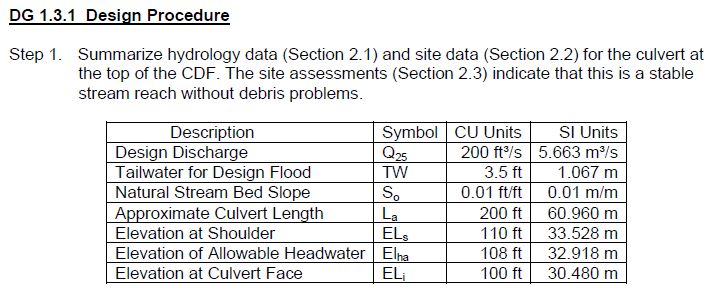

# Model Setup

A SWMM5 model is created to compare the performance curve.

Model: **./data/swmm5/dg131.inp**

- For the culvert, I didn't set any losses, entering the culvert code should handle all these automatically.
- I loaded a hydrograph from 300-0 cfs in 6 hours at node '4'.
- The depth vs total inflow in node '4' should give the performance curve
- added 3.5ft tail water at outlet
- pipe 2->3 is a big box pipe of 50ft wide to simulate the channel downstream

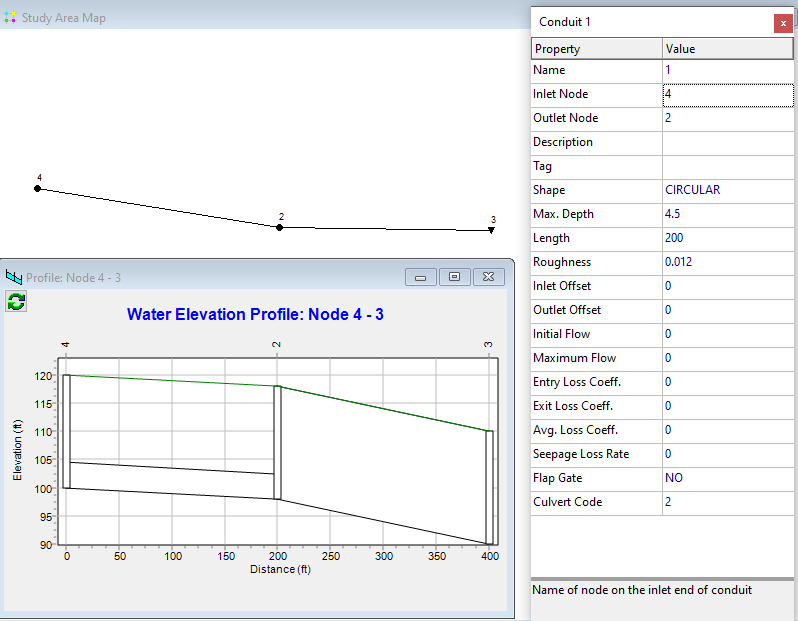

SWMM5 gives an answer of 7.93 ft for headwater depth, within 10% to HY8 result of 8.61ft.

A few things should be noted,

- SWMM5 only does culvert calculation when using the dyanmic wave option. The SWMM5 Unsteady state simulation should be more accurate than HY8 (only does steady state calculation) when flow changes fast with significant backwater influences
- For inlet control, SWMM5 shouldn't use the entrance/exit losses since the culvert routine doesn't rely on them for a correct calculation, also since SWMM5 doesn't calculate the water surface inside the pipe, the profile simply shows a straight line between the nodes. So the HGL will look very different from the HGL from  HY8
- It is not recommended to divide the culvert into smaller pieces to more accurately account for the water surface, because the way the HDS5 calculation is implemented in SWMM5. See this [thread](https://www.openswmm.org/Topic/9038/culvert-inlet-loss-comparing-hy-8-to-swmm) for more details.


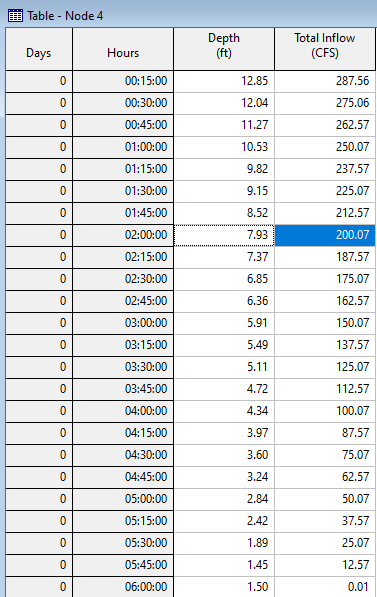

# SWMM5 vs HY8

As shown in the figure below, SWMM5 matches the HY8 results faily well, for most places they are within 10%. I am not too concerned for the area > 250 cfs, for practical purposes, a bigger culvert should be designed to handle that kind of flow.


... SWMM Version 5.3.0.dev0
... Run Complete4


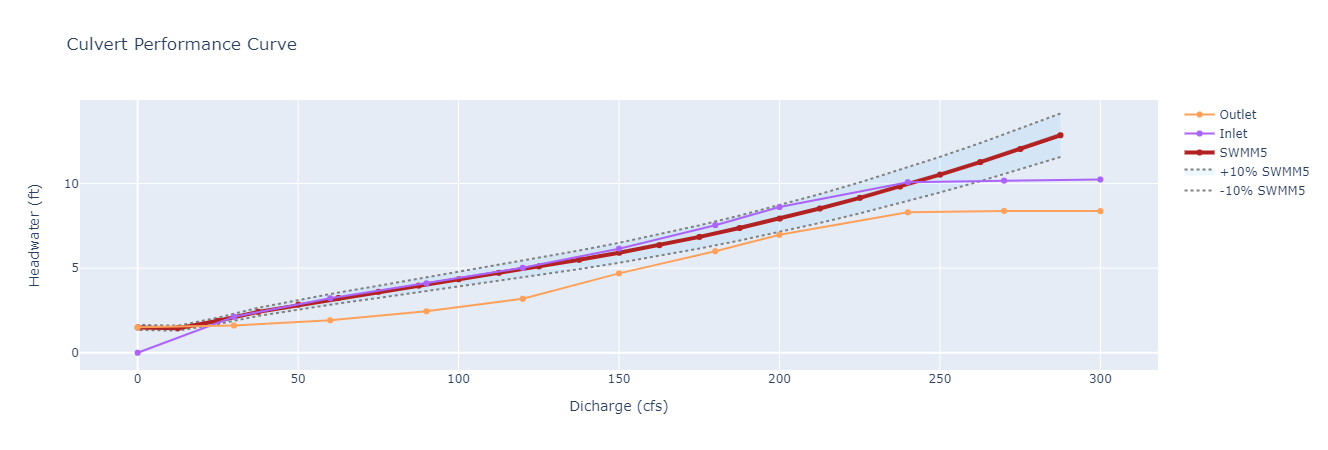

In [33]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

ws = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\references\culvert\data'

# add the base scenario
swmm_inp = os.path.join(ws, 'swmm5/dg131.inp')
swmm_out = os.path.join(ws, 'swmm5/dg131.out')
run(swmm_inp)
df_swmm5 = extract_node(swmm_out, node_name='4')

f = os.path.join(ws, "hy8/dg131_performance_curve.csv")

df = pd.read_csv(f)
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_swmm5["q"], y=df_swmm5["swmm5"]*0.9, name='-10% SWMM5', line=dict(color='grey', dash='dot')))
fig.add_trace(go.Scatter(x=df_swmm5["q"], y=df_swmm5["swmm5"]*1.1, name='+10% SWMM5', fill='tonexty',fillcolor='rgba(66, 173, 245, 0.1)',line=dict(color='grey', dash='dot') ))
fig.add_trace(go.Scatter(x=df_swmm5["q"], y=df_swmm5["swmm5"], name='SWMM5', mode='lines+markers',
                         line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=df["q"], y=df["inlet"], name='Inlet'))
fig.add_trace(go.Scatter(x=df["q"], y=df["outlet"], name='Outlet'))
fig.update_layout(title='Culvert Performance Curve', xaxis_title="Dicharge (cfs)", yaxis_title="Headwater (ft)",)
fig.show()

# Sensitivity Analysis

SWMM5 uses a unsteady state simulation, so the upstream/downstream condition can play more important role since it can introduce stability issues. Also I don't quite understand how the outlet control situation is handled since SWMM5 doesn't use FWHA equations at all.

- entrance/exit losses: for inlet control, they shouldn't matter, and for outlet control since SWMM5 doesn't use exact same calculation, it is interesting to see.
- downstream condition: in theory this shouldn't matter. In HY8 we assume the downstream velocity in the channel is very small, I would like to see if the width of a channel will have any impact
- upstream condition: for inlet control, this shouldn't matter, so let's find out.

# Entrance/Exit Loss

e02x0 means entrance=0.2, exit=0, and ex0x1 means entrance=0, exit=0.2, so we are comparing the following entrance/exit loss factors,

- 0/0,0.5/0,1/0,0/0.5, 0/1, 0/2, 0.2/1


**You need to update the path to each file in the code block below.
Run the code blocks at the end of this notebook before this one.**

In [11]:
import os
ws = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data"


results = {}
scenarios = ['e02x0', 'e05x0', 'e1x0', 'e0x05', 'e0x1', 'e0x2', 'e02x1']
# scenarios = ['loss1', 'loss2', 'loss3']
for sc in scenarios: 
    swmm_inp = os.path.join(ws, 'swmm5/dg131_%s.inp' % sc)
    swmm_out = os.path.join(ws, 'swmm5/dg131_%s.out' % sc)
    run(swmm_inp)
    results[sc] = extract_node(swmm_out, node_name='4')
    print(sc)
    print(results[sc])

# add the base scenario
swmm_inp = os.path.join(ws, 'swmm5/dg131.inp')
swmm_out = os.path.join(ws, 'swmm5/dg131.out')
run(swmm_inp)
results['base'] = extract_node(swmm_out, node_name='4')
plot_results(results, scenarios)


... SWMM Version 5.3.0.dev0
... Run Complete4
e02x0
                         swmm5           q
2020-05-28 00:00:00  12.853357  287.562897
2020-05-28 00:15:00  12.041612  275.064728
2020-05-28 00:30:00  11.265922  262.566406
2020-05-28 00:45:00  10.526278  250.067749
2020-05-28 01:00:00   9.822718  237.569382
2020-05-28 01:15:00   9.154978  225.069427
2020-05-28 01:30:00   8.523647  212.569427
2020-05-28 01:45:00   7.928207  200.069427
2020-05-28 02:00:00   7.368853  187.569427
2020-05-28 02:15:00   6.845573  175.069427
2020-05-28 02:30:00   6.358367  162.569427
2020-05-28 02:45:00   5.907237  150.069427
2020-05-28 03:00:00   5.492122  137.569427
2020-05-28 03:15:00   5.106722  125.069427
2020-05-28 03:30:00   4.722830  112.569427
2020-05-28 03:45:00   4.342566  100.069427
2020-05-28 04:00:00   3.967034   87.569427
2020-05-28 04:15:00   3.599984   75.069427
2020-05-28 04:30:00   3.237018   62.569431
2020-05-28 04:45:00   2.842197   50.069431
2020-05-28 05:00:00   2.417089   37.569431
2

FigureWidget({
    'data': [{'name': 'base',
              'type': 'scatter',
              'uid': '0e81107c-4…

# Losses Conclusion
It looks that only when exit loss = 2 will push the curve upward significantly, all other settings seems to produce the same results. However, an exit loss of 2 is too high for most applications.

Since we already know most of the time it is inlet control, it confirmed my understanding for inlet control culvert, the losses are not playing an important role in deciding the headwater. 



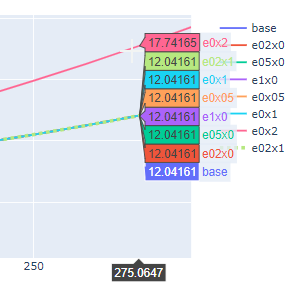

# Inlet Setting

Since the headwater is calculated as the water depth of the inlet node of the culvert, I would like to see what will impact its depth.

- base:loading directly to the inlet
- storage:loading directly to the inlet, which is modeled as a storage node
- channel: loading to a big channel which then flows into the inlet

storage1k and storage10k are two scenarios with different storage size.


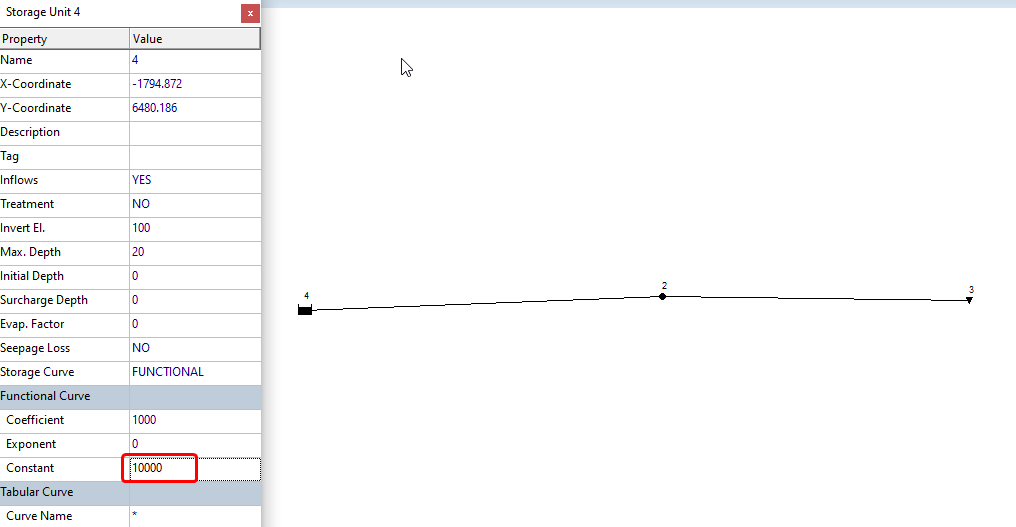

In [12]:
import os
ws = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\references\culvert\data"


results = {}
scenarios = ['storage1k', 'storage10k']
# scenarios = ['loss1', 'loss2', 'loss3']
for sc in scenarios: 
    swmm_inp = os.path.join(ws, 'swmm5/dg131_%s.inp' % sc)
    swmm_out = os.path.join(ws, 'swmm5/dg131_%s.out' % sc)
    run(swmm_inp)
    results[sc] = extract_node(swmm_out, node_name='4')
    print(sc)
    print(results[sc])

# add the base scenario
swmm_inp = os.path.join(ws, 'swmm5/dg131.inp')
swmm_out = os.path.join(ws, 'swmm5/dg131.out')
run(swmm_inp)
results['base'] = extract_node(swmm_out, node_name='4')
plot_results(results, scenarios)


... SWMM Version 5.3.0.dev0
... Run Complete4
storage1k
                         swmm5           q
2020-05-28 00:00:00  12.967530  287.562653
2020-05-28 00:15:00  12.166387  275.064423
2020-05-28 00:30:00  11.379475  262.566162
2020-05-28 00:45:00  10.629086  250.067520
2020-05-28 01:00:00   9.915277  237.569138
2020-05-28 01:15:00   9.238091  225.069427
2020-05-28 01:30:00   8.597565  212.569427
2020-05-28 01:45:00   7.993590  200.069427
2020-05-28 02:00:00   7.426223  187.569427
2020-05-28 02:15:00   6.895414  175.069427
2020-05-28 02:30:00   6.401205  162.569427
2020-05-28 02:45:00   5.943610  150.069427
2020-05-28 03:00:00   5.522667  137.569427
2020-05-28 03:15:00   5.134791  125.069427
2020-05-28 03:30:00   4.751618  112.569427
2020-05-28 03:45:00   4.368518  100.069427
2020-05-28 04:00:00   3.982565   87.569427
2020-05-28 04:15:00   3.618818   75.069427
2020-05-28 04:30:00   3.263344   62.569431
2020-05-28 04:45:00   2.871217   50.069431
2020-05-28 05:00:00   2.439167   37.5694

FigureWidget({
    'data': [{'name': 'base',
              'type': 'scatter',
              'uid': '1c529ae6-b…

## Storage Conclusion

Looks like storage has very little impact on the results, SWMM5 is able to use the culvert calculation to set the head at the storage node.

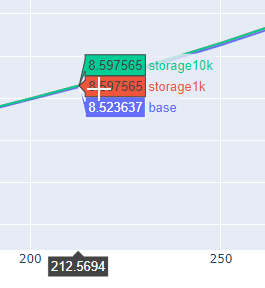

## Inlet Channel

Instead of loading directly at the culvert inlet (4), I loaded flow at a box channel at node 5, I adjusted the width of the inlet channel to see if it will make any differences.

channel10 is 10ft wide box, and channel200 is 200ft wide box.

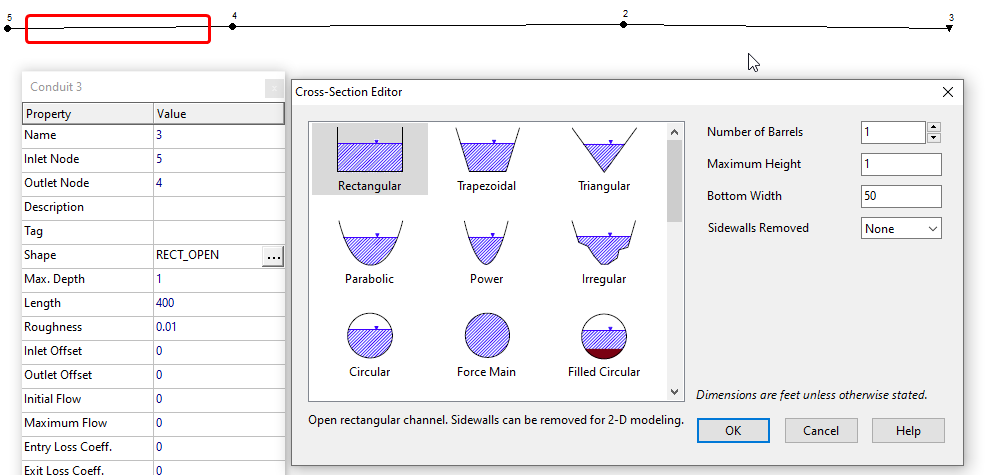

In [13]:
import os
ws = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\references\culvert\data"


results = {}
scenarios = ['channel10', 'channel50', 'channel200']
# scenarios = ['loss1', 'loss2', 'loss3']
for sc in scenarios: 
    swmm_inp = os.path.join(ws, 'swmm5/dg131_%s.inp' % sc)
    swmm_out = os.path.join(ws, 'swmm5/dg131_%s.out' % sc)
    run(swmm_inp)
    results[sc] = extract_node(swmm_out, node_name='4')
    print(sc)
    print(results[sc])

# add the base scenario
swmm_inp = os.path.join(ws, 'swmm5/dg131.inp')
swmm_out = os.path.join(ws, 'swmm5/dg131.out')
run(swmm_inp)
results['base'] = extract_node(swmm_out, node_name='4')
plot_results(results, scenarios)


... SWMM Version 5.3.0.dev0
... Run Complete4
channel10
                         swmm5           q
2020-05-28 00:00:00  11.535628  266.977112
2020-05-28 00:15:00  11.535628  266.977112
2020-05-28 00:30:00  11.266804  262.590790
2020-05-28 00:45:00  10.526217  250.092560
2020-05-28 01:00:00   9.822950  237.593582
2020-05-28 01:15:00   9.155277  225.095398
2020-05-28 01:30:00   8.523691  212.594193
2020-05-28 01:45:00   7.928186  200.092957
2020-05-28 02:00:00   7.369232  187.595673
2020-05-28 02:15:00   6.845858  175.094193
2020-05-28 02:30:00   6.358565  162.592667
2020-05-28 02:45:00   5.907356  150.091095
2020-05-28 03:00:00   5.492721  137.589355
2020-05-28 03:15:00   5.114943  125.293953
2020-05-28 03:30:00   4.735682  112.784294
2020-05-28 03:45:00   4.374789  100.278885
2020-05-28 04:00:00   3.985945   87.755775
2020-05-28 04:15:00   3.622932   75.258575
2020-05-28 04:30:00   3.269477   62.769089
2020-05-28 04:45:00   2.876002   50.210346
2020-05-28 05:00:00   2.445149   37.7267

FigureWidget({
    'data': [{'name': 'base',
              'type': 'scatter',
              'uid': 'e2d16f8f-4…

## Channel Conclusion

For different channel widths, they produce very similar results as the base scenario. At low flow region channel200 and channel50 produced slightly higher headwater. And I think that is most likely a result of unsteady state simulation, for bigger channels at low flow conditions, it takes some time to reach steady state level. When I run a constant flow, the level is much closer to the base scenario.

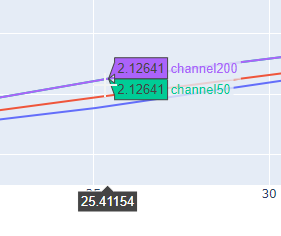

# Summary

As shown in this post, it is not that hard to conduct sensitivity analysis. I think the important lesson from this exercise is that rather than focus on finding general statements such as "SWMM5 can accurately model culvert using FHWA HDS5 methods or not.", just do some sensitivity analysis, I don't think anyone who wrote the software should be responsible for my modeling results. For the kind of complex system we are modeling everyday, nobody can promise everything will work as intended. So let's set out how things should be, test it and work with the issues!

# Run the code blocks below first

In [2]:
from swmm.output import output as smo
import pandas as pd
import datetime
from pyswmm import Simulation, Subcatchments
import matplotlib.pyplot as plt

def run(inp_path):
    sim = Simulation(inp_path)
    sim.execute()
    

def swmm_dt(days):
    # convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1


def extract_node(out_path, node_name):
    # extract the rainfall results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)
    node_index = 0
    while True:
        if smo.getelementname(handle, smo.ElementType.NODE, node_index) == node_name:
            break
        node_index += 1
    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.NODE, node_index))

    # get the time sereis from the out file
    depth = smo.getnodeseries(handle, node_index, smo.NodeAttribute.INVERT_DEPTH, 0, num_steps)
    q = smo.getnodeseries(handle, node_index, smo.NodeAttribute.TOTAL_INFLOW, 0, num_steps)
    df = pd.DataFrame({'swmm5': depth, 'q': q}, index=timestep)
    return df



In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_performance_curve(hy8_curve_csv, swmm5_out, xpswmm_csv, node_name):
    df = pd.read_csv(hy8_curve_csv)
    df_swmm = extract_node(swmm5_out, node_name)
    df_xp = pd.read_csv(xpswmm_csv)
    ax = df.plot(x='q', y='inlet', label='Inlet', style='x-', figsize=(10,10))
    ax = df.plot(x='q', y='outlet', label='Outlet', style='.-', ax=ax)
    ax = df_swmm.plot(x='q', y='swmm5', label='SWMM5', style='o-', ax=ax)
    ax.fill_between(df_swmm['q'], df_swmm['swmm5']*0.9, df_swmm['swmm5']*1.1, alpha=0.2)
    ax = df_xp.plot(x='q', y='xpswmm', label='XPSWMM', style='o-', ax=ax)
    plt.xlabel('Discharge(cfs)')
    plt.ylabel('Headwater(ft)')
    plt.title('SWMM5 culvert vs HY8')
    plt.grid(True)
    plt.show()
    

In [10]:
import plotly.graph_objects as go

def plot_results(results, scenarios):
    fig = go.FigureWidget()
    for sc in ['base'] + scenarios:
        df = results[sc]
        if sc == 'e02x1':
            fig.add_trace(go.Scatter(
            x=df['q'], y=df['swmm5'],
            name = sc,
            line=dict(color='light blue', width=4, dash='dot')
        ))
        else:
            fig.add_trace(go.Scatter(
            x=df['q'], y=df['swmm5'],
            name = sc
        ))
    return fig